# Analysing Shopping Trends

## Importing Libraries

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from pyspark import SparkContext
sc= SparkContext()

from pyspark.sql import SQLContext
sql= SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Loading the dataset

In [7]:
file_path = "shopping_trends.csv"

In [18]:
myData = sql.read.csv(file_path, header = True)

In [19]:
myData.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Purchase Amount (USD): string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Review Rating: string (nullable = true)
 |-- Subscription Status: string (nullable = true)
 |-- Shipping Type: string (nullable = true)
 |-- Discount Applied: string (nullable = true)
 |-- Promo Code Used: string (nullable = true)
 |-- Previous Purchases: string (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Frequency of Purchases: string (nullable = true)



In [20]:
myData.show()

+-----------+---+------+--------------+-----------+---------------------+-------------+----+---------+------+-------------+-------------------+--------------+----------------+---------------+------------------+--------------+----------------------+
|Customer ID|Age|Gender|Item Purchased|   Category|Purchase Amount (USD)|     Location|Size|    Color|Season|Review Rating|Subscription Status| Shipping Type|Discount Applied|Promo Code Used|Previous Purchases|Payment Method|Frequency of Purchases|
+-----------+---+------+--------------+-----------+---------------------+-------------+----+---------+------+-------------+-------------------+--------------+----------------+---------------+------------------+--------------+----------------------+
|          1| 55|  Male|        Blouse|   Clothing|                   53|     Kentucky|   L|     Gray|Winter|          3.1|                Yes|       Express|             Yes|            Yes|                14|         Venmo|           Fortnightly|
|   

In [21]:
# Summary statistics of numerical columns
myData.describe()


DataFrame[summary: string, Customer ID: string, Age: string, Gender: string, Item Purchased: string, Category: string, Purchase Amount (USD): string, Location: string, Size: string, Color: string, Season: string, Review Rating: string, Subscription Status: string, Shipping Type: string, Discount Applied: string, Promo Code Used: string, Previous Purchases: string, Payment Method: string, Frequency of Purchases: string]

In [22]:
myData.first()

Row(Customer ID='1', Age='55', Gender='Male', Item Purchased='Blouse', Category='Clothing', Purchase Amount (USD)='53', Location='Kentucky', Size='L', Color='Gray', Season='Winter', Review Rating='3.1', Subscription Status='Yes', Shipping Type='Express', Discount Applied='Yes', Promo Code Used='Yes', Previous Purchases='14', Payment Method='Venmo', Frequency of Purchases='Fortnightly')

## Data cleaning

In [ ]:
# Drop duplicates, if any
myData = myData.dropDuplicates()

In [ ]:
# Drop rows with missing values
myData = myData.na.drop()

In [29]:
# Check for null values in the dataset
for col in myData.columns:
    null_count = myData.filter(myData[col].isNull()).count()
    print(f"Number of null values in {col}: {null_count}")

# Summary statistics
myData.describe().show(truncate=False)


Number of null values in Customer ID: 0
Number of null values in Age: 0
Number of null values in Gender: 0
Number of null values in Item Purchased: 0
Number of null values in Category: 0
Number of null values in Purchase Amount (USD): 0
Number of null values in Location: 0
Number of null values in Size: 0
Number of null values in Color: 0
Number of null values in Season: 0
Number of null values in Review Rating: 0
Number of null values in Subscription Status: 0
Number of null values in Shipping Type: 0
Number of null values in Discount Applied: 0
Number of null values in Promo Code Used: 0
Number of null values in Previous Purchases: 0
Number of null values in Payment Method: 0
Number of null values in Frequency of Purchases: 0
+-------+-----------------+------------------+------+--------------+-----------+---------------------+--------+----+------+------+------------------+-------------------+--------------+----------------+---------------+------------------+--------------+-----------

## Data Exploration

## Total records

In [23]:
# Count the number of records in the dataset
total_records = myData.count()
print("Total number of records: ", total_records)


Total number of records:  3900


## Average purchase amount by customers

In [24]:
# Calculate the average purchase amount
average_purchase_amount = myData.agg({"Purchase Amount (USD)": "avg"}).collect()[0][0]
print("Average Purchase Amount: $", round(average_purchase_amount, 2))


Average Purchase Amount: $ 59.76


## Total number of categories

In [25]:
# Find unique categories of items purchased
unique_categories = myData.select("Category").distinct().rdd.map(lambda x: x[0]).collect()
print("Unique Categories: ", unique_categories)


Unique Categories:  ['Outerwear', 'Clothing', 'Footwear', 'Accessories']


## Top 5 items based on purchase amount

In [26]:
# Find the top N items based on the purchase amount
top_items = myData.rdd.map(lambda x: (x["Item Purchased"], float(x["Purchase Amount (USD)"]))).\
    reduceByKey(lambda x, y: x + y).\
    sortBy(lambda x: x[1], ascending=False).\
    take(5)
print("Top Purchased Items: ", top_items)


Top Purchased Items:  [('Blouse', 10410.0), ('Shirt', 10332.0), ('Dress', 10320.0), ('Pants', 10090.0), ('Jewelry', 10010.0)]


## Purchases based on age group

In [27]:
# Calculate the average purchase frequency by age group
age_group_frequency = myData.rdd.map(lambda x: (int(x["Age"]) // 10 * 10, 1)).\
    reduceByKey(lambda x, y: x + y).\
    sortByKey().\
    collect()
print("Purchase Frequency by Age Group: ", age_group_frequency)


Purchase Frequency by Age Group:  [(10, 150), (20, 728), (30, 724), (40, 739), (50, 771), (60, 721), (70, 67)]


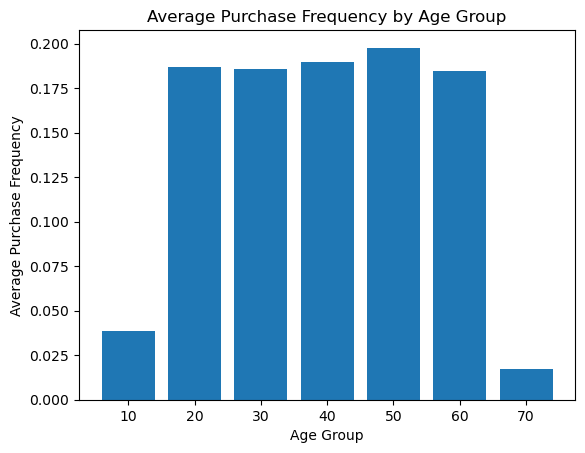

In [45]:

# Unpack the data for plotting
age_groups, frequencies = zip(*age_group_frequency)

# Calculate average purchase frequency
average_frequency = [freq / total_records for freq in frequencies]

# Plotting the bar chart
plt.bar(age_groups, average_frequency, width=8)  # You can adjust the width as needed
plt.xlabel('Age Group')
plt.ylabel('Average Purchase Frequency')
plt.title('Average Purchase Frequency by Age Group')
plt.show()


## Average review rating based on gender

In [28]:
# Calculate the average review rating by gender
review_rating_gender = myData.rdd.map(lambda x: (x["Gender"], (float(x["Review Rating"]), 1))).\
    reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).\
    mapValues(lambda x: x[0] / x[1]).\
    collect()
print("Average Review Rating by Gender: ", review_rating_gender)


Average Review Rating by Gender:  [('Male', 3.753959276018097), ('Female', 3.7414262820512842)]


## Location-wise total purchase amount

In [30]:
# Calculate the total purchase amount for each location
location_purchase_amount = myData.rdd.map(lambda x: (x["Location"], float(x["Purchase Amount (USD)"]))).\
    reduceByKey(lambda x, y: x + y).\
    collect()
print("Location-wise Purchase Amount: ", location_purchase_amount)


Location-wise Purchase Amount:  [('Texas', 4712.0), ('Nebraska', 5172.0), ('West Virginia', 5174.0), ('Oregon', 4243.0), ('North Carolina', 4742.0), ('New Mexico', 5014.0), ('Georgia', 4645.0), ('Ohio', 4649.0), ('Maine', 4388.0), ('Louisiana', 4848.0), ('Montana', 5784.0), ('North Dakota', 5220.0), ('Wyoming', 4309.0), ('Arkansas', 4828.0), ('Connecticut', 4226.0), ('Alaska', 4867.0), ('California', 5605.0), ('Kansas', 3437.0), ('Colorado', 4222.0), ('Rhode Island', 3871.0), ('Mississippi', 4883.0), ('Maryland', 4795.0), ('Delaware', 4758.0), ('Kentucky', 4402.0), ('Oklahoma', 4376.0), ('Pennsylvania', 4926.0), ('New Hampshire', 4219.0), ('Illinois', 5617.0), ('New York', 5257.0), ('New Jersey', 3802.0), ('Missouri', 4691.0), ('South Dakota', 4236.0), ('Hawaii', 3752.0), ('Wisconsin', 4196.0), ('Idaho', 5587.0), ('Tennessee', 4772.0), ('Indiana', 4655.0), ('Alabama', 5261.0), ('Washington', 4623.0), ('Virginia', 4842.0), ('Massachusetts', 4384.0), ('South Carolina', 4439.0), ('Vermont

## Payment Method Distribution

In [31]:
# Calculate the distribution of payment methods
payment_method_distribution = myData.rdd.map(lambda x: (x["Payment Method"], 1)).\
    reduceByKey(lambda x, y: x + y).\
    collect()
print("Payment Method Distribution: ", payment_method_distribution)


Payment Method Distribution:  [('Cash', 670), ('Venmo', 634), ('PayPal', 677), ('Credit Card', 671), ('Bank Transfer', 612), ('Debit Card', 636)]


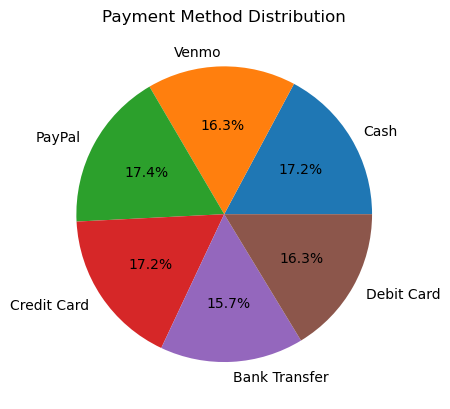

In [40]:
plt.pie([count for method, count in payment_method_distribution], labels=[method for method, count in payment_method_distribution], autopct='%1.1f%%')
plt.title('Payment Method Distribution')
plt.show()


## Total purchase frequency for each season


In [32]:
# Calculate the total purchase frequency for each season
season_purchase_frequency = myData.rdd.map(lambda x: (x["Season"], 1)).\
    reduceByKey(lambda x, y: x + y).\
    collect()
print("Purchase Frequency by Season: ", season_purchase_frequency)


Purchase Frequency by Season:  [('Fall', 975), ('Spring', 999), ('Winter', 971), ('Summer', 955)]


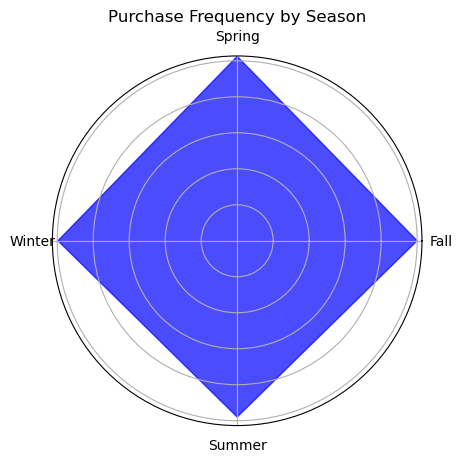

In [51]:


# Unpack the data for plotting
seasons, frequencies = zip(*season_purchase_frequency)

# Calculate total purchase frequency
total_records = myData.count()
total_frequency = sum(frequencies)

# Calculate the percentage of purchase frequency for each season
percentage_frequency = [freq / total_frequency * 100 for freq in frequencies]

# Convert the seasons to radians for the radar chart
theta = np.linspace(0, 2 * np.pi, len(seasons), endpoint=False)

# Plotting the radar chart
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.fill(theta, percentage_frequency, color='b', alpha=0.7)

# Add labels and title
ax.set_xticks(theta)
ax.set_xticklabels(seasons)
ax.set_yticklabels([])  # Hide y-axis labels for better readability
ax.set_title('Purchase Frequency by Season')

# Show the plot
plt.show()


## Average Purchase Amount by Category

In [33]:
# Calculate the average purchase amount for each category
category_avg_purchase = myData.rdd.map(lambda x: (x["Category"], (float(x["Purchase Amount (USD)"]), 1))).\
    reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).\
    mapValues(lambda x: x[0] / x[1]).\
    collect()
print("Average Purchase Amount by Category: ", category_avg_purchase)


Average Purchase Amount by Category:  [('Accessories', 59.83870967741935), ('Clothing', 60.025331030512376), ('Footwear', 60.25542570951586), ('Outerwear', 57.17283950617284)]


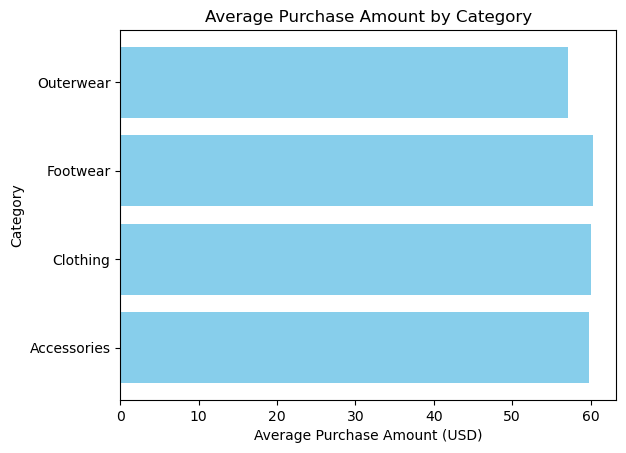

In [52]:

# Unpack the data for plotting
categories, avg_purchase = zip(*category_avg_purchase)

# Plotting the horizontal bar chart
plt.barh(categories, avg_purchase, color='skyblue')
plt.xlabel('Average Purchase Amount (USD)')
plt.ylabel('Category')
plt.title('Average Purchase Amount by Category')
plt.show()


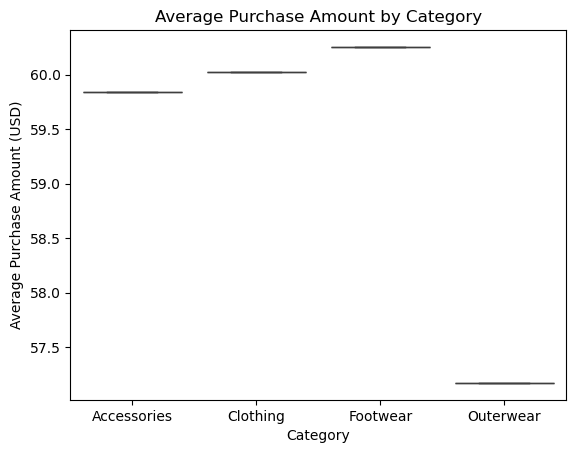

In [42]:

categories, avg_purchase = zip(*category_avg_purchase)
sns.boxplot(x=categories, y=avg_purchase)
plt.xlabel('Category')
plt.ylabel('Average Purchase Amount (USD)')
plt.title('Average Purchase Amount by Category')
plt.show()


## Distribution of subscription status

In [34]:
# Calculate the distribution of subscription status
subscription_status_distribution = myData.rdd.map(lambda x: (x["Subscription Status"], 1)).\
    reduceByKey(lambda x, y: x + y).\
    collect()
print("Subscription Status Distribution: ", subscription_status_distribution)


Subscription Status Distribution:  [('Yes', 1053), ('No', 2847)]


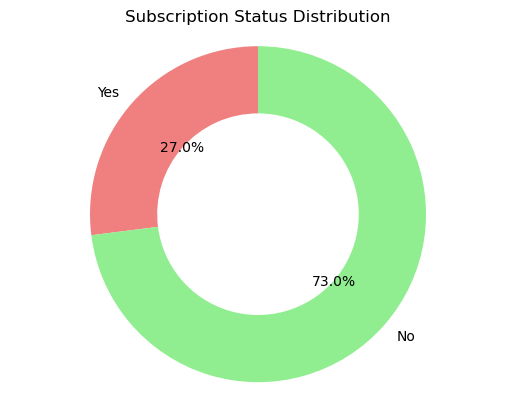

In [53]:
# Unpack the data for plotting
statuses, counts = zip(*subscription_status_distribution)

# Plotting the donut chart
fig, ax = plt.subplots()
ax.pie(counts, labels=statuses, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=['lightcoral', 'lightgreen'])
ax.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Add a circle at the center to create a donut chart
center_circle = plt.Circle((0, 0), 0.3, color='white', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Add a title
plt.title('Subscription Status Distribution')

# Show the plot
plt.show()
